# Model evaluation using Sidekick

Use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

Note: This notebook requires installation of Sidekick. For more information about this package, see:
https://github.com/Peltarion/sidekick

In [1]:
from glob import glob
import itertools
import os
import operator
import resource

from IPython.display import display, Image
import pandas as pd
from PIL import Image
from tqdm import tqdm
import sidekick
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Setup

### Paths

In [2]:
#preprocessed dataset
dataset_path = '/Users/joakim/rep/fruits/fruits-360/Test'
#os.chdir(dataset_path)

In [4]:
!pwd

/Users/joakim/rep/fruits


### Client to deployment

In [5]:
#Update the URL and token

# Original
#deployment_url = 'https://a.peltarion.com/deployment/5f2a2f7a-cad0-44a8-8217-0ff9f0e4fd3e/forward'
#deployment_token = '8c0032e4-6204-4b23-ab14-90fc2a644408'

# Granny smith
#deployment_url='https://a.peltarion.com/deployment/f2ccfa6c-4fb5-474a-a5cd-7a358654dfd8/forward'
#deployment_token='5f629eb5-1c7b-4511-a0f8-c57a00678756'

#95/5
deployment_url='https://a.peltarion.com/deployment/31c92c6e-6bd0-4e50-9888-20b930434b85/forward'
deployment_token='73ead620-4c89-4ba8-9786-58fbc261c5fd'

client = sidekick.Deployment(
    url=deployment_url,
    token=deployment_token,
    dtypes_in={'image': 'Image (100x100x3)'},
    dtypes_out={'class': 'Categorical (103)'}
)

### Helper functions

In [6]:
def get_max_score(pred):
    max_key = 'None'
    max_score = 0
    dict = pred['class'].items()
    for key,score in dict:
        if score >= max_score:        
            max_key = key
            max_score = score
    return (max_key, max_score)


def get_image(path):
    im = Image.open(path)
    new_im = im.copy()
    new_im.format = 'jpeg'
    im.close()
    return new_im

### Progress bars for pandas

In [7]:
tqdm.pandas()

## Create test dataframe - ground truth

In [13]:
images_rel_path = glob(dataset_path + '/*/*.jpg') + glob(dataset_path + '/*/*.png')
print("Images found: ", len(images_rel_path))

Images found:  17845


In [14]:
df = pd.DataFrame({'image': images_rel_path})
df['class'] = df['image'].progress_apply(lambda path: os.path.basename(os.path.dirname(path)))
df = df.sample(frac=1).reset_index(drop=True)
df.head()

100%|██████████| 17845/17845 [00:00<00:00, 296887.25it/s]


,image,class
0,/Users/joakim/rep/fruits/fruits-360/Test/Banan...,Banana Lady Finger
1,/Users/joakim/rep/fruits/fruits-360/Test/Banan...,Banana Red
2,/Users/joakim/rep/fruits/fruits-360/Test/Orang...,Orange
3,/Users/joakim/rep/fruits/fruits-360/Test/Kumqu...,Kumquats
4,/Users/joakim/rep/fruits/fruits-360/Test/Peach...,Peach 2


## Single  predictions

In [15]:
im_path_list = iter(list(df['image']))

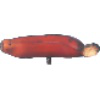

('Banana Red', 0.99935085)


In [17]:
im_path = next(im_path_list)
im = Image.open(im_path)
display(im)
pred = client.predict(image=im)
print(get_max_score(pred))

## Multiple predictions

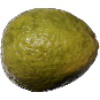

Ground truth: Guava
Prediction: Guava


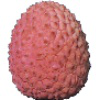

Ground truth: Lychee
Prediction: Lychee


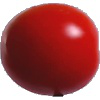

Ground truth: Tomato 4
Prediction: Tomato 4


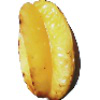

Ground truth: Carambula
Prediction: Carambula


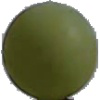

Ground truth: Grape White 4
Prediction: Grape White 4


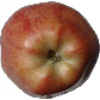

Ground truth: Apple Red 1
Prediction: Apple Red 1


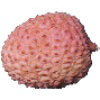

Ground truth: Lychee
Prediction: Lychee


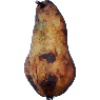

Ground truth: Pear Abate
Prediction: Pear Abate


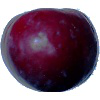

Ground truth: Plum 2
Prediction: Plum 2


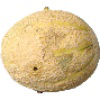

Ground truth: Cantaloupe 2
Prediction: Cantaloupe 2


In [18]:
rows = df.sample(n=10)
for i, row in rows.iterrows():
    im = Image.open(row['image'])    
    display(im)
    pred = client.predict(image=im)
    print('Ground truth: {}\nPrediction: {}'.format(row['class'], get_max_score(pred)[0]))

## Worst misclassified

Copy the image URLs to a new column.
Create a new column that contains the actual images.

In [19]:
eval_df = df.copy()
eval_df['image_url'] = eval_df['image']
eval_df['image'] = eval_df['image'].progress_apply(lambda path: get_image(path))
predictions = client.predict_lazy(eval_df.to_dict('record'))

100%|██████████| 17845/17845 [00:15<00:00, 1143.31it/s]


Get all the predictions, this will take several minutes.
Store the predictions in a new column.

(This may take several minutes)

In [20]:
pbar = tqdm(total=len(eval_df))
preds = []
for p in predictions:
    preds.append(p)
    pbar.update(1)
pbar.close()

100%|██████████| 17845/17845 [33:33<00:00,  8.86it/s] 


In [21]:
#preds = [p for p in predictions]
eval_df['pred'] = [p['class'] for p in preds]
eval_df.head(5)

,image,class,image_url,pred
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Banana Lady Finger,/Users/joakim/rep/fruits/fruits-360/Test/Banan...,"{'Apple Granny Smith': 7.5313494e-21, 'Grapefr..."
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Banana Red,/Users/joakim/rep/fruits/fruits-360/Test/Banan...,"{'Apple Granny Smith': 4.791123e-21, 'Grapefru..."
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Orange,/Users/joakim/rep/fruits/fruits-360/Test/Orang...,"{'Apple Granny Smith': 1.018207e-23, 'Grapefru..."
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Kumquats,/Users/joakim/rep/fruits/fruits-360/Test/Kumqu...,"{'Apple Granny Smith': 1.4581285e-26, 'Grapefr..."
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Peach 2,/Users/joakim/rep/fruits/fruits-360/Test/Peach...,"{'Apple Granny Smith': 1.8496301e-24, 'Grapefr..."


Create new columns that contain the name of highest scoring class and the score.

In [22]:
dicts = eval_df['pred']
max_keys = []
max_scores = []

for i in dicts:
    max_val = max(i.items(), key=lambda k: k[1])     
    max_keys.append(max_val[0])
    max_scores.append(max_val[1])
eval_df['pred_class'] = max_keys
eval_df['pred_score'] = max_scores
eval_df.head(5)

,image,class,image_url,pred,pred_class,pred_score
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Banana Lady Finger,/Users/joakim/rep/fruits/fruits-360/Test/Banan...,"{'Apple Granny Smith': 7.5313494e-21, 'Grapefr...",Banana Lady Finger,1.000000
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Banana Red,/Users/joakim/rep/fruits/fruits-360/Test/Banan...,"{'Apple Granny Smith': 4.791123e-21, 'Grapefru...",Banana Red,0.999351
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Orange,/Users/joakim/rep/fruits/fruits-360/Test/Orang...,"{'Apple Granny Smith': 1.018207e-23, 'Grapefru...",Orange,1.000000
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Kumquats,/Users/joakim/rep/fruits/fruits-360/Test/Kumqu...,"{'Apple Granny Smith': 1.4581285e-26, 'Grapefr...",Kumquats,0.999707
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Peach 2,/Users/joakim/rep/fruits/fruits-360/Test/Peach...,"{'Apple Granny Smith': 1.8496301e-24, 'Grapefr...",Peach 2,1.000000


Get the top-ten samples with the highest prediction score and incorrect label.

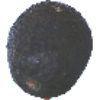

Ground truth: Avocado ripe, Prediction: Avocado, Score: 0.9999217


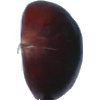

Ground truth: Chestnut, Prediction: Hazelnut, Score: 0.99991274


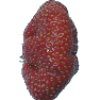

Ground truth: Strawberry Wedge, Prediction: Salak, Score: 0.9998987


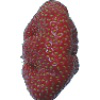

Ground truth: Strawberry Wedge, Prediction: Salak, Score: 0.99987304


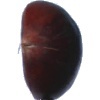

Ground truth: Chestnut, Prediction: Hazelnut, Score: 0.99985325


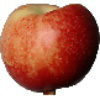

Ground truth: Nectarine, Prediction: Apple Braeburn, Score: 0.9998479


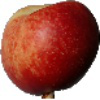

Ground truth: Nectarine, Prediction: Peach, Score: 0.99974984


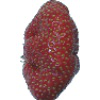

Ground truth: Strawberry Wedge, Prediction: Salak, Score: 0.9997061


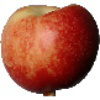

Ground truth: Nectarine, Prediction: Apple Braeburn, Score: 0.9996835


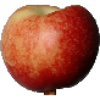

Ground truth: Nectarine, Prediction: Apple Braeburn, Score: 0.99967444


In [23]:
wrong_df = eval_df.loc[eval_df['class'] != eval_df['pred_class']]
wrong_df = wrong_df.sort_values(by=['pred_score'], ascending=False)
first_rows = wrong_df.head(10)
for i, row in first_rows.iterrows():
    display(row['image'])
    print('Ground truth: {}, Prediction: {}, Score: {}'.format(row['class'], row['pred_class'], row['pred_score']))

### Number of miclassified Apple Granny Smith

In [24]:
df_granny_smith = wrong_df.loc[df['class'] == 'Apple Granny Smith']
print(df_granny_smith.shape[0])

19


### View all misclassified samples in class Apple Granny Smith

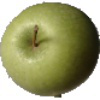

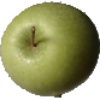

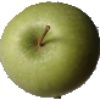

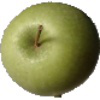

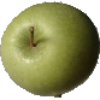

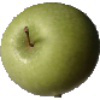

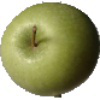

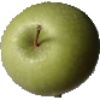

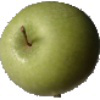

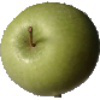

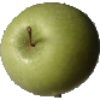

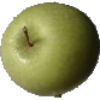

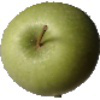

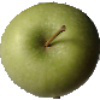

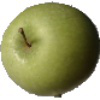

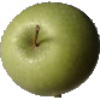

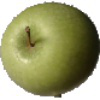

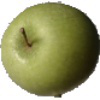

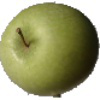

In [25]:
for i, row in df_granny_smith.iterrows():
    im = row['image']
    display(im)

## Classification report

In [26]:
print(classification_report(y_pred=eval_df['pred_class'], y_true=eval_df['class']))

                     precision    recall  f1-score   support

     Apple Braeburn       0.85      1.00      0.92       164
 Apple Crimson Snow       1.00      0.99      1.00       148
     Apple Golden 1       1.00      0.99      1.00       164
     Apple Golden 2       1.00      0.96      0.98       164
     Apple Golden 3       0.88      1.00      0.94       161
 Apple Granny Smith       1.00      0.88      0.94       164
    Apple Pink Lady       0.95      1.00      0.97       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       1.00      0.86      0.92       164
        Apple Red 3       1.00      0.99      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.99      1.00       164
 Apple Red Yellow 2       0.94      1.00      0.97       219
            Apricot       1.00      0.90      0.95       164
            Avocado       0.82      0.97      0.89       143
       Avocado ripe    

## Overall accuracy

In [27]:
1-wrong_df.shape[0]/df.shape[0]

0.9818996917904175